In [11]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import time
from datetime import datetime
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import seaborn as sns
import json

In [12]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=30,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv3 = Conv2d(in_channels=30, out_channels=40,
			kernel_size=(5, 5))
		self.relu3 = ReLU()
		self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv4 = Conv2d(in_channels=40, out_channels=50,
			kernel_size=(5, 5))
		self.relu4 = ReLU()
		self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv5 = Conv2d(in_channels=50, out_channels=60,
			kernel_size=(5, 5))
		self.relu5 = ReLU()
		self.maxpool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=540, out_features=500)
		self.relu6 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		#print(f"shape after first conv: {x.shape}")
		x = self.relu1(x)
		x = self.maxpool1(x)
		#print(f"shape after first maxpool: {x.shape}")
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		#print(f"shape after second conv: {x.shape}")
		x = self.relu2(x)
		x = self.maxpool2(x)
		#print(f"shape after second maxpool: {x.shape}")

		x = self.conv3(x)
		#print(f"shape after third conv: {x.shape}")
		x = self.relu3(x)
		x = self.maxpool3(x)
		#print(f"shape after third maxpool: {x.shape}")

		x = self.conv4(x)
		#print(f"shape after fourth conv: {x.shape}")
		x = self.relu4(x)
		x = self.maxpool4(x)
		#print(f"shape after fourth maxpool: {x.shape}")

		x = self.conv5(x)
		#print(f"shape after fifth conv: {x.shape}")
		x = self.relu5(x)
		x = self.maxpool5(x)
		#print(f"shape after fifth maxpool: {x.shape}")
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		#print(f"shape after flatten: {x.shape}")
		x = self.fc1(x)
		x = self.relu6(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

In [13]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
		image = np.load(img_path)
		label = self.y[idx]
		return image, label


In [14]:
DATA_PATH = '../../../birdclef-2022-data'
AUDIO_PATH = '../../../birdclef-2022-data/train_audio'
IMAGE_PATH = '../../../birdclef-2022-data/train_images/'
All_BUT_LAST = True
ONLY_FIRST = False
SEED = 42

# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
# collect data about data structure
def create_first_clip():
    all_data = []
    for primary_label in os.listdir(IMAGE_PATH):
        all_data += [primary_label + '/' +
                        x for x in os.listdir(IMAGE_PATH + primary_label) if x.endswith('_0.npy')
                        ]
    all_data += ['maupar/XC123887_1.npy']
    results = create_annotated_dataframe(all_data)
    return results

def create_all_clips():
    all_data = []
    for primary_label in os.listdir(IMAGE_PATH):
        directories = os.listdir(IMAGE_PATH + primary_label)
        if All_BUT_LAST:
            if len(directories) > 1:
                directories = directories[:-1]
            all_data += [primary_label + '/' + x for x in directories]
        else:
            all_data += [primary_label + '/' + x for x in directories]
    results = create_annotated_dataframe(all_data)
    return results

def create_annotated_dataframe(all_data):
    base_data = {'file_name': [], 'label': []}
    for item in all_data:
        base_data['file_name'].append(item)
        base_data['label'].append(item.split('/')[0])
    results = create_encoded_dataframe(base_data)
    return results

def create_encoded_dataframe(base_data):
    results = pd.DataFrame(base_data, columns = ['file_name', 'label'])
    le = LabelEncoder()
    labels = le.fit_transform(results['label'])
    results['label'] = np.int64(labels)
    return results

In [16]:
def stratified_split(dataset):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  dataset['label'].to_numpy(),
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    train = CustomDataset(x_train, y_train, IMAGE_PATH)
    val = CustomDataset(x_val, y_val, IMAGE_PATH)
    return train, val

In [17]:
dataset = create_first_clip() if ONLY_FIRST else create_all_clips()
train, val = stratified_split(dataset)

In [18]:
trainDataLoader = DataLoader(train, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(val, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [19]:
# initialize the LeNet model
torch.manual_seed(SEED)
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=3,
	classes=len(train.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
class_acc = []
metrics = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": [],
	"f1score": []
}

[INFO] initializing the LeNet model...


In [20]:

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
	print(f"[INFO] starting training for epoch: {e + 1} at {datetime.now().strftime('%H:%M:%S')}")
	preds = []
	target = []
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for data in tqdm(trainDataLoader, desc="training progress"):
		# send the input to the device
		x, y = data
		x = x.transpose(1, 3)
		x = x.transpose(2, 3)
		x = x.float()
		x, y = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
		# add predictions and targets for F1score and per class accuracy tracking
		for item in pred:
			preds.append(np.argmax(item.cpu().detach().numpy()))
		target.extend(y.cpu().detach().numpy())

	# switch off autograd for evaluation
	with torch.no_grad():
		print(f"[INFO] starting evaluation for epoch: {e + 1} at {datetime.now().strftime('%H:%M:%S')}")
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in tqdm(valDataLoader, desc="validation progress"):
			x = x.transpose(1, 3)
			x = x.transpose(2, 3)
			x = x.float()
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# calculate per class accuracy via confusion matrix
	matrix = confusion_matrix(target, preds)
	class_acc.append(matrix.diagonal()/matrix.sum(axis=1))
	# calculate macro F1 score
	f1epoch = f1_score(target, preds, average='macro')
	# update our training history
	metrics["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	metrics["train_acc"].append(trainCorrect)
	metrics["val_loss"].append(avgValLoss.cpu().detach().numpy())
	metrics["val_acc"].append(valCorrect)
	metrics['f1score'].append(f1epoch)
	# print the model training and validation information
	print(f"""
	[INFO] EPOCH: {e + 1}/{EPOCHS}
	Train loss: {avgTrainLoss :.6f}, Train accuracy: {trainCorrect :.4f}
	Val loss: 	{avgValLoss :.6f}, Val accuracy:   {valCorrect :.4f}
	F1: 		{f1epoch :.6f}
	---------------------------------------------------- \n
	""")

# finish measuring how long training took
endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

[INFO] training the network...
[INFO] starting training for epoch: 1 at 19:20:20


training progress: 100%|██████████| 1696/1696 [08:29<00:00,  3.33it/s] 


[INFO] starting evaluation for epoch: 1 at 19:28:50


validation progress: 100%|██████████| 566/566 [01:41<00:00,  5.55it/s]



	[INFO] EPOCH: 1/10
	Train loss: 3.050765, Train accuracy: 0.2986
	Val loss: 	2.597187, Val accuracy:   0.3945
	F1: 		0.101305
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 2 at 19:30:32


training progress: 100%|██████████| 1696/1696 [07:37<00:00,  3.70it/s]


[INFO] starting evaluation for epoch: 2 at 19:38:10


validation progress: 100%|██████████| 566/566 [01:42<00:00,  5.54it/s]



	[INFO] EPOCH: 2/10
	Train loss: 2.312163, Train accuracy: 0.4446
	Val loss: 	2.228132, Val accuracy:   0.4742
	F1: 		0.227648
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 3 at 19:39:52


training progress: 100%|██████████| 1696/1696 [07:32<00:00,  3.75it/s]


[INFO] starting evaluation for epoch: 3 at 19:47:24


validation progress: 100%|██████████| 566/566 [01:53<00:00,  4.98it/s]



	[INFO] EPOCH: 3/10
	Train loss: 2.039628, Train accuracy: 0.5002
	Val loss: 	2.116093, Val accuracy:   0.4974
	F1: 		0.316892
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 4 at 19:49:18


training progress: 100%|██████████| 1696/1696 [08:03<00:00,  3.51it/s]


[INFO] starting evaluation for epoch: 4 at 19:57:21


validation progress: 100%|██████████| 566/566 [01:47<00:00,  5.26it/s]



	[INFO] EPOCH: 4/10
	Train loss: 1.867280, Train accuracy: 0.5358
	Val loss: 	2.097575, Val accuracy:   0.5034
	F1: 		0.381646
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 5 at 19:59:09


training progress: 100%|██████████| 1696/1696 [07:27<00:00,  3.79it/s]


[INFO] starting evaluation for epoch: 5 at 20:06:36


validation progress: 100%|██████████| 566/566 [01:44<00:00,  5.42it/s]



	[INFO] EPOCH: 5/10
	Train loss: 1.751356, Train accuracy: 0.5618
	Val loss: 	2.025819, Val accuracy:   0.5242
	F1: 		0.434351
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 6 at 20:08:21


training progress: 100%|██████████| 1696/1696 [08:18<00:00,  3.40it/s]


[INFO] starting evaluation for epoch: 6 at 20:16:39


validation progress: 100%|██████████| 566/566 [01:41<00:00,  5.56it/s]



	[INFO] EPOCH: 6/10
	Train loss: 1.657335, Train accuracy: 0.5823
	Val loss: 	2.000130, Val accuracy:   0.5369
	F1: 		0.466891
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 7 at 20:18:21


training progress: 100%|██████████| 1696/1696 [07:37<00:00,  3.71it/s]


[INFO] starting evaluation for epoch: 7 at 20:25:59


validation progress: 100%|██████████| 566/566 [01:40<00:00,  5.64it/s]



	[INFO] EPOCH: 7/10
	Train loss: 1.585358, Train accuracy: 0.5951
	Val loss: 	1.945445, Val accuracy:   0.5546
	F1: 		0.497396
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 8 at 20:27:40


training progress: 100%|██████████| 1696/1696 [08:06<00:00,  3.49it/s]


[INFO] starting evaluation for epoch: 8 at 20:35:46


validation progress: 100%|██████████| 566/566 [01:55<00:00,  4.89it/s]



	[INFO] EPOCH: 8/10
	Train loss: 1.521088, Train accuracy: 0.6099
	Val loss: 	1.986043, Val accuracy:   0.5507
	F1: 		0.522524
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 9 at 20:37:42


training progress: 100%|██████████| 1696/1696 [07:39<00:00,  3.69it/s]


[INFO] starting evaluation for epoch: 9 at 20:45:22


validation progress: 100%|██████████| 566/566 [01:41<00:00,  5.59it/s]



	[INFO] EPOCH: 9/10
	Train loss: 1.472565, Train accuracy: 0.6204
	Val loss: 	2.194768, Val accuracy:   0.5370
	F1: 		0.541499
	---------------------------------------------------- 

	
[INFO] starting training for epoch: 10 at 20:47:03


training progress: 100%|██████████| 1696/1696 [07:45<00:00,  3.64it/s]


[INFO] starting evaluation for epoch: 10 at 20:54:49


validation progress: 100%|██████████| 566/566 [01:40<00:00,  5.64it/s]



	[INFO] EPOCH: 10/10
	Train loss: 1.427604, Train accuracy: 0.6287
	Val loss: 	2.172915, Val accuracy:   0.5445
	F1: 		0.564053
	---------------------------------------------------- 

	
[INFO] total time taken to train the model: 96.16min


In [21]:
# prepare data for final evaluation metric output
with open(f"{DATA_PATH}/scored_birds.json") as f:
    scored = json.load(f)

labels_raw = [x for x in os.listdir(IMAGE_PATH)]

le = LabelEncoder()
le.fit(labels_raw)
scored_encoded = le.transform(scored)
accs_last_epoch = class_acc[-1]
acc_scored = [accs_last_epoch[x] for x in scored_encoded]
output = f"""
last epoch values:
train loss: {metrics["train_loss"][-1]}
train acc:  {metrics["train_acc"][-1]}
val loss:   {metrics["val_loss"][-1]}
val acc:    {metrics["val_acc"][-1]}
F1:         {metrics['f1score'][-1]}
"""
print(output)
print(f"per class accuracy after last epoch: \n {accs_last_epoch}")


last epoch values:
train loss: 1.427603840827942
train acc:  0.6287286097365439
val loss:   2.172914505004883
val acc:    0.5445498023387609
F1:         0.5640534757245832

per class accuracy after last epoch: 
 [0.51190476 0.66037736 0.61676647 0.39495798 0.5625     0.33333333
 0.38571429 0.36386139 0.54017094 0.81528662 0.62802908 0.44210526
 0.51716501 0.69612711 0.73033708 0.54823529 0.54545455 0.35174419
 0.54155496 0.7027027  0.32608696 0.75435624 0.43037975 0.4
 0.4125     0.88461538 0.65420561 0.25345622 0.69122807 0.53562802
 0.71359437 0.65517241 0.41798942 0.5907173  0.6        0.6
 0.50239234 0.30588235 0.53271889 0.78816877 0.5        0.76812661
 0.69493594 0.75       0.72222222 0.5709912  0.21296296 0.5
 0.4872449  0.52866242 0.42828685 0.62714988 0.50431034 0.59468938
 0.66216216 0.41330998 0.64423077 0.51785714 0.3006135  0.60349462
 0.325      0.55319149 0.70822281 0.54054054 0.82926829 0.64
 0.47794118 0.60498883 0.83517034 0.61111111 0.48093842 0.62121212
 0.3772727

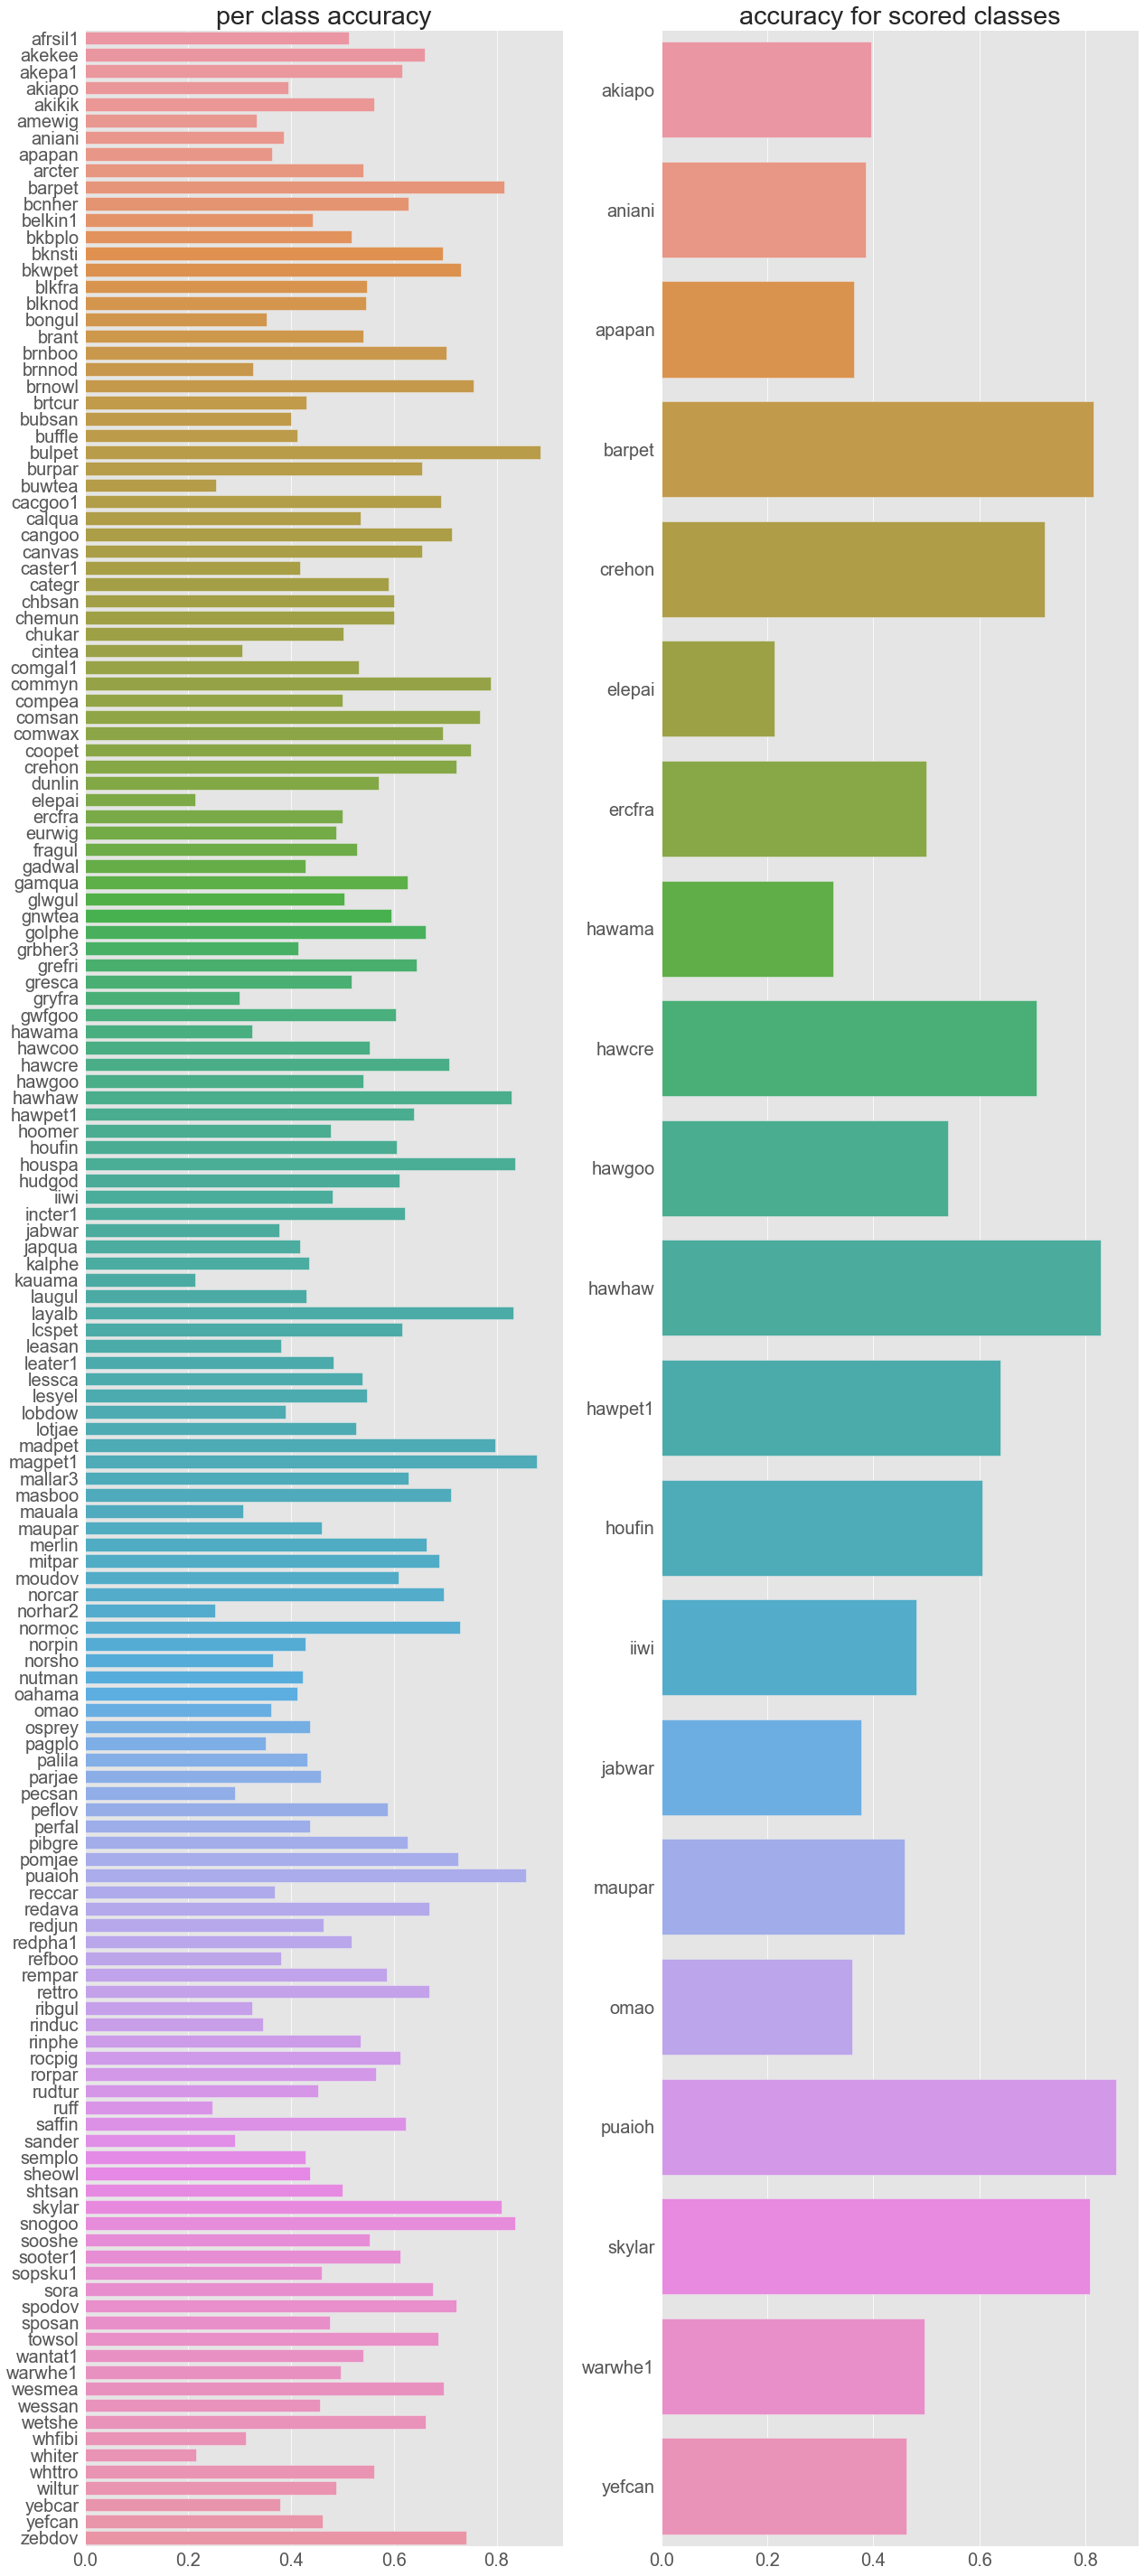

In [22]:
# plot per class accuracy for all classes and only the scored classes
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,40))
sns.barplot(x=accs_last_epoch, y=os.listdir(IMAGE_PATH), ax = ax[0])
sns.barplot(x=acc_scored, y=scored, ax = ax[1], dodge=False)
ax[0].set_title("per class accuracy")
ax[1].set_title("accuracy for scored classes")
plt.tight_layout()

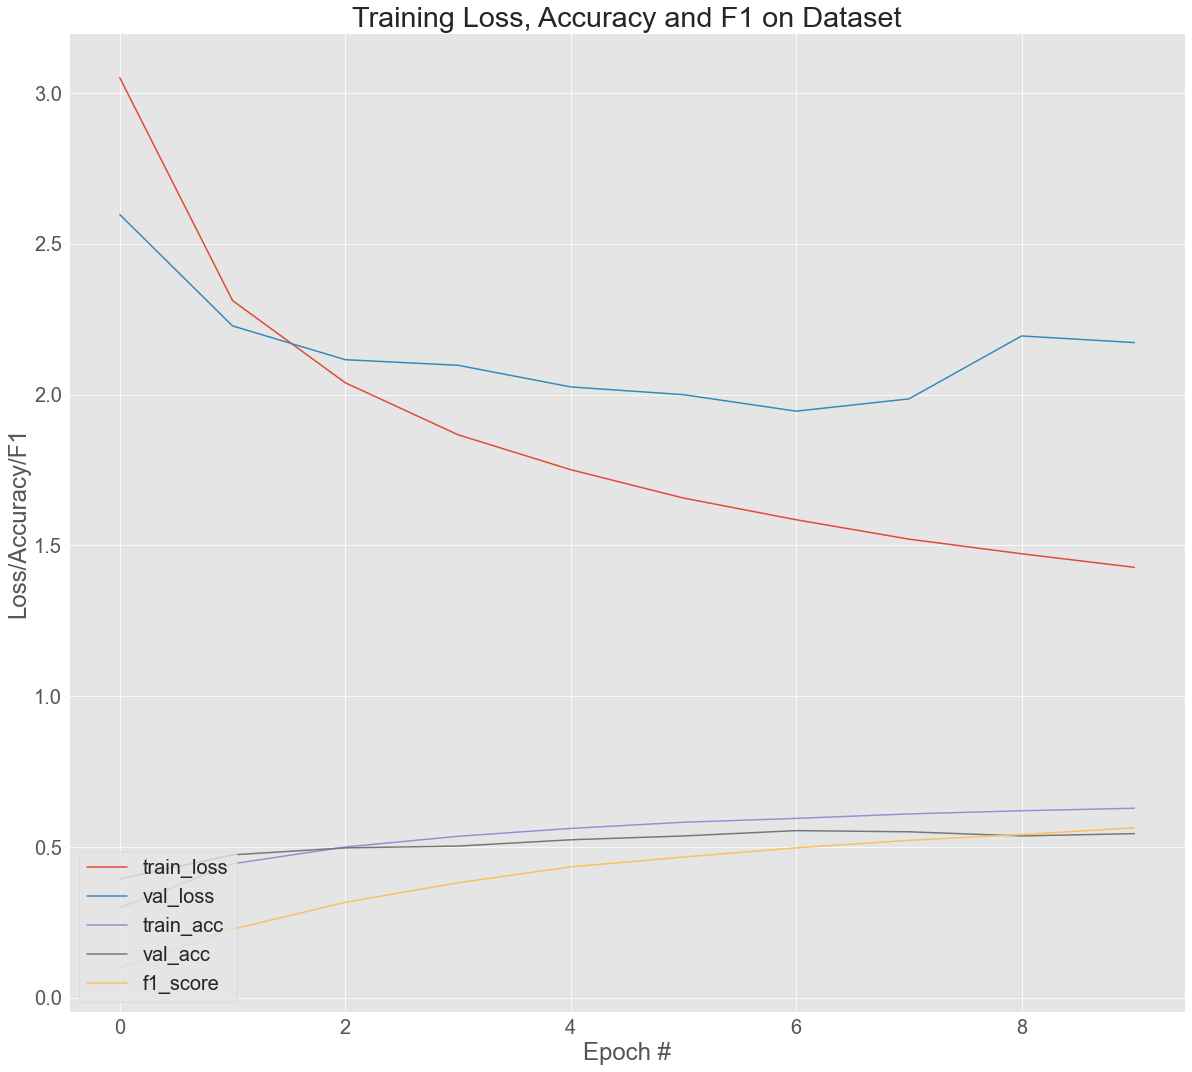

In [23]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 18))
plt.plot(metrics["train_loss"], label="train_loss")
plt.plot(metrics["val_loss"], label="val_loss")
plt.plot(metrics["train_acc"], label="train_acc")
plt.plot(metrics["val_acc"], label="val_acc")
plt.plot(metrics["f1score"], label="f1_score")
plt.title("Training Loss, Accuracy and F1 on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(loc="lower left")